# Geo-spatial analysis of assisted living data

In this notebook we're going to try to do a cool analysis of AL need.

The stat we're trying to come up with is: If everyone with AL need had the ability and desire to get to an ALF, how far would an individual have to travel to get to a bed?

Here what we have done and have to do:

1. [x]  Get PUMA disability data for the US by querying census data
1. [x]  Turn raw PUMA data into need counts for each PUMA
1. [x]  Convert PUMA data into county data
1. [x]  Get locations for each county
1. [x]  Figure out distance to travel from one county's centroid to neighboring beds
1. [x]  Create dynamic variable of what percent of need is already satisfied (with home care, family options, etc...)
1. [ ]  Get travel times in different areas
1. [ ]  Figure out how to better model need geographically. I.e. instead of centroids, more dispersed population
1. [ ]  Figure out how to solve constrained optimization problem of bed allocation for optimal travel times

## Importing

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd

import json
import requests

import pickle

import time

import matplotlib
import matplotlib.pyplot as plt

import altair as alt
from vega_datasets import data

from scipy.spatial import KDTree

import plotly.express as px
import plotly.graph_objects as go

In [106]:
import chart_studio
import chart_studio.plotly as py

import chart_studio.tools as tls
chart_studio.tools.set_credentials_file(username='antonstengel', api_key='RFpfpkiXaFzkAxNnf1Xj')

In [2]:
disabilities = ['DOUT', 'DPHY', 'DREM', 'DDRS']

In [3]:
columns = ['Address',
 'Capacity',
 'City',
 'County',
 'Date Accessed',
 'Email Address',
 'Facility ID',
 'Facility Name',
 'Latitude',
 'License Number',
 'Licensee',
 'Longitude',
 'Ownership Type',
 'Phone Number',
 'State',
 'State Facility Type 1 Literal',
 'State Facility Type 2 Literal',
 'Zip Code']

cols_to_title = ['City', 'County', 'Facility Name']
cols_to_lower = ['Email Address']
cols_to_upper = ['Address', 'State Facility Type 1 Literal', 'State Facility Type 2 Literal', 'Ownership Type', 'Licensee']

## Functions

In [4]:
# cleaner function
# adds state abbreviation
# fixes capitalization
# removes some duplicates and shows you how many remaining
def cleaner(df):
    # finding wrong columns
    print('Extraneous columns are:\n{}'.format(list(set(df.columns) - set(columns))))

    # df['State'] = state

    # fixing capitalization
    for col in df.columns:
        if   col in cols_to_title: df[col] = df[col].str.title()
        elif col in cols_to_lower: df[col] = df[col].str.lower()
        elif col in cols_to_upper: df[col] = df[col].str.upper()


    if 'License Number' in df.columns:
        df.drop_duplicates(['Facility Name', 'License Number'], inplace=True)
        print('{} ALFs, {} unique License Numbers, {} NA License Numbers'.format(df.shape[0], df['License Number'].unique().shape[0], df['License Number'].isna().sum()))
    elif 'Facility ID' in df.columns:
        df.drop_duplicates(['Facility Name', 'Facility ID'], inplace=True)
        print('{} ALFs, {} unique Facility IDs, {} NA Facility IDs'.format(df.shape[0], df['Facility ID'].unique().shape[0], df['Facility ID'].isna().sum()))
    else:
        df.drop_duplicates(['Facility Name', 'Address'], inplace=True)
        print('No License Number or Facility ID')

### Functions to get disability data

In [5]:
# takes a row of df and returns 0 for no disability, 1 for ALF, 2 for NH
disability_status_helper = lambda x: 1 if x == 1 else 0

def get_disability_status(row):
    if row['DDRS'] == 1:
        return 2
    elif row[disabilities].apply(disability_status_helper).sum() >= 2:
        return 2
    elif row[disabilities].apply(disability_status_helper).sum() == 1:
        return 1
    else:
        return 0

In [6]:
# NEW DISABILITY METRIC
def get_disability_status_new(row):
    if row['DDRS'] == 1:
        return 1
    elif row[disabilities].apply(disability_status_helper).sum() >= 2:
        return 1
    else:
        return 0

In [7]:
# takes a df of disability data and returns column of disability status
def get_disability_status_column(df):
    temp = df.apply(get_disability_status, axis=1)
    return temp

In [8]:
# takes a df of disability data and returns column of disability status
def get_disability_status_column_new(df):
    temp = df.apply(get_disability_status_new, axis=1)
    return temp

In [9]:
# takes a df with a disability status column and populates the number of people in each puma with 'ALF' and 'NH' needs and returns dictionary
def count_disabilities(df):
    disability_dict = {'ALF':{}, 'NH':{}}
    for puma in df['PUMA'].unique():
        temp = df[df['PUMA'] == puma]

        disability_dict['ALF'][puma] = temp.loc[temp['Disability Status'] == 1, 'PWGTP'].sum()
        disability_dict['NH'][puma] = temp.loc[temp['Disability Status'] == 2, 'PWGTP'].sum()
    return disability_dict

In [10]:
# function that takes list of PUMA's and returns query string to get data from the PUMA's
def query_str(pumas):
    return url_base + '7950000US' + ',7950000US'.join(pumas)

In [11]:
# takes state abbreviation and returns df of relevent pums data for all PUMA's in state
# have to break request into chunks so census website gives proper response
# no request has more then 50 PUMA's in it
def get_pums_data(state):
    temp = puma_codes_df[puma_codes_df['State Code'] == state_code_dict[state]]['Full Code'].values

    num_parts = np.ceil(temp.shape[0] / 50)
    temp_split = np.array_split(temp, num_parts)

    urls = list(map(query_str, temp_split))
    jsons = [requests.get(url).json() for url in urls]
    dfs = [pd.DataFrame(json[1:], columns=json[0]).astype(int) for json in jsons]
    return pd.concat(dfs)

### Functions to calculate distances

In [12]:
# takes a row of county df with lat long and returns nearest facilities to satisfy ALF need * scalar
def get_alf_neighbors(row, scalar, capacity_type):
    assert scalar > 0 and scalar <= 1

    coord = [row['Latitude'], row['Longitude']]
    num_facilities = 5

    d, i = alf_kdtree.query(coord, k = num_facilities)

    if county_disability_dict.get(row['FIPS']) is None:
        print("Dictionary of county disability information doesn't have county with FIPS {}".format(row['FIPS']))
        return 0

    while alf_df.iloc[i][capacity_type].sum() < (county_disability_dict[row['FIPS']]['ALF'] * scalar):
        num_facilities += 5
        d, i = alf_kdtree.query(coord, k = num_facilities)
    return alf_df.iloc[i]

In [13]:
# takes a row of county df with lat long and returns nearest facilities to satisfy NH need * scalar
def get_nh_neighbors(row, scalar):
    assert scalar > 0 and scalar <= 1

    coord = [row['Latitude'], row['Longitude']]
    num_facilities = 5

    d, i = nh_kdtree.query(coord, k = num_facilities)

    if county_disability_dict.get(row['FIPS']) is None:
        print("Dictionary of county disability information doesn't have county with FIPS {}".format(row['FIPS']))
        return 0

    while nh_df.iloc[i]['Number of Certified Beds'].sum() < (county_disability_dict[row['FIPS']]['NH'] * scalar):
        num_facilities += 5
        d, i = nh_kdtree.query(coord, k = num_facilities)
    return nh_df.iloc[i]

In [14]:
# takes a row and a df and returns mean distance in miles from the row's lat/long to lat/long of each item in df, using the Haversine formula. See https://stackoverflow.com/questions/27928/calculate-distance-between-two-latitude-longitude-points-haversine-formula for where the code came from
def mean_distance(row, df):
    p = np.pi/180
    return np.mean(3959.87433 * 2 * np.arcsin(np.sqrt(  0.5 -  np.cos((row['Latitude']-df['Latitude'])*p)/2 + np.cos(df['Latitude']*p) * np.cos(row['Latitude']*p) * (1-np.cos((row['Longitude'] - df['Longitude'])*p))/2)))

In [15]:
# combine neighbors and mean distance
def get_mean_distance_to_alf(row, scalar, capacity_type):
    return mean_distance(row, get_alf_neighbors(row, scalar, capacity_type))

# combine neighbors and mean distance
def get_mean_distance_to_nh(row, scalar):
    return mean_distance(row, get_nh_neighbors(row, scalar))

## Variables

In [24]:
# dictionary for disability data of each state and each PUMA
with open("../data/other-data/disability-puma-data.pkl", 'rb') as f:
    puma_disability_dict = pickle.load(f)

with open("../data/other-data/disability-puma-data-new.pkl", 'rb') as f:
    puma_disability_dict_new = pickle.load(f)

# ALF dataset
# alf_df = pd.read_pickle('alf-datasets/national/national-dataset-1-with-coordinates.pkl')
# alf_df.drop(alf_df[alf_df['State'] == '52'].index, inplace = True) # dropping one weird row
# grabbing new dataset as of 8/27/21 with all states but AK, ND, and VA
# alf_df = pd.read_csv('alf-datasets/national/national-dataset-48states-with-coords-and-county-8-28-21.csv')
alf_df = pd.read_csv('../alf-dataset.csv')

# list of states that we have ALF data for
states_with_alf_data = alf_df['State'].unique()

# NH dataset
# nh_df = pd.read_pickle('../../nh/data/nh-data/nh-long-1.pkl')

# Useful state info dataset we've already made
state_info_df = pd.read_pickle('../data/other-data/state-info-with-extras.pkl')

# dictionary of state abbriviation to state code using our state_info dataset
state_code_dict = dict(zip(state_info_df['abbreviation'], state_info_df['id']))

# PUMA county equivalence file and adding useful columns
puma_county_equivalence_df = pd.read_csv('../data/other-data/puma-county-equivalence.csv')
puma_county_equivalence_df['Full Puma Code'] = puma_county_equivalence_df.apply(lambda x: str(x['State code']).zfill(2) + str(x['PUMA (2012)']).zfill(5), axis=1)

puma_county_equivalence_df['ALF need'] = puma_county_equivalence_df.apply(lambda x: puma_disability_dict[x['State abbreviation']]['ALF'][x['PUMA (2012)']], axis=1)
puma_county_equivalence_df['ALF need new'] = puma_county_equivalence_df.apply(lambda x: puma_disability_dict_new[x['State abbreviation']]['ALF'][x['PUMA (2012)']], axis=1)
puma_county_equivalence_df['NH need'] = puma_county_equivalence_df.apply(lambda x: puma_disability_dict[x['State abbreviation']]['NH'][x['PUMA (2012)']], axis=1)



puma_county_equivalence_df['Scaled county ALF need'] = puma_county_equivalence_df['puma12 to county allocation factor'] * puma_county_equivalence_df['ALF need']
puma_county_equivalence_df['Scaled county ALF need new'] = puma_county_equivalence_df['puma12 to county allocation factor'] * puma_county_equivalence_df['ALF need new']
puma_county_equivalence_df['Scaled county NH need'] = puma_county_equivalence_df['puma12 to county allocation factor'] * puma_county_equivalence_df['NH need']

# getting county fips and lat/long coord info
county_info_df = pd.read_csv('../data/other-data/county-coords.csv')
county_info_df['Latitude'] = county_info_df['Latitude'].apply(lambda x: float(x[1:-1]))
county_info_df['Longitude'] = county_info_df['Longitude'].apply(lambda x: -1 * float(x[1:-1]))

# 65+ population per county (2015-2019)
county_oldpopulation_df = pd.read_csv('../data/county-data-for-replication/county-age-65.csv')
county_oldpopulation_df.columns = ['County', 'State', 'FIPS', 'Formatted FIPS', '65+ Population']

# PUMA codes
#puma_codes_df = pd.read_csv('../data/other-data/2010-puma-names.csv')
#puma_codes_df.drop(columns='PUMA NAME', inplace=True)
#puma_codes_df['Full Code'] = puma_codes_df.apply(lambda x: str(x['STATEFP']).zfill(2) + str(x['PUMA5CE']).zfill(5), axis=1)
#puma_codes_df.rename(columns={'STATEFP':'State Code','PUMA5CE':'PUMA Code'}, inplace=True)

# just add puma codes to end of this url and use for request
url_base = 'https://api.census.gov/data/2019/acs/acs1/pums?get=PWGTP,DOUT,DREM,DPHY,DDRS&ucgid='

In [25]:
cleaner(alf_df)

Extraneous columns are:
['County Poverty Rate', 'County Median Household Income', 'County Percent of Population 85 or Older', 'County Median Home Value of Owned Homes', 'County Percent Black Population', 'County FIPS', 'County Percent Hispanic Population', 'County Gender Ratio', 'County Unemployment Rate', 'County Less Than High School Diploma Rate', 'County Percent of Population 65 or Older', 'Total County AL Need', 'County College Education or Higher Rate', 'County Percent Whilte Population', 'County Homeownership Rate', 'County Median Age']
43399 ALFs, 20507 unique License Numbers, 22507 NA License Numbers


## Getting disability data

In [26]:
# populates puma_disability_dict with all NH and ALF data for every PUMA for every state
# already done this and stored data in alf-datasets/national/disability-puma-data.pkl
# codes takes ~ 30 mins to run
'''
puma_disability_dict = {}
for state in list(state_code_dict.keys()):
    start = time.time()
    temp = get_pums_data(state)
    end = time.time()
    print('{:.2f}s to get {} data.'.format(end-start, state), end=' ', flush=True)

    start = time.time()
    temp['Disability Status'] = get_disability_status_column(temp)
    puma_disability_dict[state] = count_disabilities(temp)
    end = time.time()
    print('{:.2f}s to count disability info.'.format(end-start), flush=True)

with open("alf-datasets/national/disability-puma-data.pkl", "wb") as f: 
    pickle.dump(puma_disability_dict, f)
'''

'\npuma_disability_dict = {}\nfor state in list(state_code_dict.keys()):\n    start = time.time()\n    temp = get_pums_data(state)\n    end = time.time()\n    print(\'{:.2f}s to get {} data.\'.format(end-start, state), end=\' \', flush=True)\n\n    start = time.time()\n    temp[\'Disability Status\'] = get_disability_status_column(temp)\n    puma_disability_dict[state] = count_disabilities(temp)\n    end = time.time()\n    print(\'{:.2f}s to count disability info.\'.format(end-start), flush=True)\n\nwith open("alf-datasets/national/disability-puma-data.pkl", "wb") as f: \n    pickle.dump(puma_disability_dict, f)\n'

In [27]:
'''
puma_disability_dict_new = {}
for state in list(state_code_dict.keys()):
    start = time.time()
    temp = get_pums_data(state)
    end = time.time()
    print('{:.2f}s to get {} data.'.format(end-start, state), end=' ', flush=True)

    start = time.time()
    temp['Disability Status'] = get_disability_status_column_new(temp)
    puma_disability_dict_new[state] = count_disabilities(temp)
    end = time.time()
    print('{:.2f}s to count disability info.'.format(end-start), flush=True)

with open("alf-datasets/national/disability-puma-data-new.pkl", "wb") as f: 
    pickle.dump(puma_disability_dict_new, f)
'''

'\npuma_disability_dict_new = {}\nfor state in list(state_code_dict.keys()):\n    start = time.time()\n    temp = get_pums_data(state)\n    end = time.time()\n    print(\'{:.2f}s to get {} data.\'.format(end-start, state), end=\' \', flush=True)\n\n    start = time.time()\n    temp[\'Disability Status\'] = get_disability_status_column_new(temp)\n    puma_disability_dict_new[state] = count_disabilities(temp)\n    end = time.time()\n    print(\'{:.2f}s to count disability info.\'.format(end-start), flush=True)\n\nwith open("alf-datasets/national/disability-puma-data-new.pkl", "wb") as f: \n    pickle.dump(puma_disability_dict_new, f)\n'

In [28]:
# THIS IS THE OLD COUNTY DISABILITY DICT
'''# converts disability data about PUMA's into disability data about counties
county_disability_dict = {}
for county in puma_county_equivalence_df['County code'].unique():
    county_disability_dict[county] = {'ALF': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county ALF need'].sum(), 
                                 'NH': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county NH need'].sum()}
                                 
# APPARRENTLY 2270 IS A COUNTY WE ARE MISSING SO JUST GONNA SET IT TO 0
county_disability_dict[2270] = {'ALF':0, 'NH': 0}'''

"# converts disability data about PUMA's into disability data about counties\ncounty_disability_dict = {}\nfor county in puma_county_equivalence_df['County code'].unique():\n    county_disability_dict[county] = {'ALF': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county ALF need'].sum(), \n                                 'NH': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county NH need'].sum()}\n                                 \n# APPARRENTLY 2270 IS A COUNTY WE ARE MISSING SO JUST GONNA SET IT TO 0\ncounty_disability_dict[2270] = {'ALF':0, 'NH': 0}"

In [29]:
# THIS USES THE NEW METRIC INSTEAD

# converts disability data about PUMA's into disability data about counties
county_disability_dict = {}
for county in puma_county_equivalence_df['County code'].unique():
    county_disability_dict[county] = {'ALF': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county ALF need new'].sum(), 
                                 'NH': puma_county_equivalence_df[puma_county_equivalence_df['County code'] == county]['Scaled county NH need'].sum()}
                                 
# APPARRENTLY 2270 IS A COUNTY WE ARE MISSING SO JUST GONNA SET IT TO 0
county_disability_dict[2270] = {'ALF':0, 'NH': 0}

## General statistics

In [30]:
# THIS DOESN'T REALLY MAKE SENSE ANYMORE
print('There are {:,.0f} people who have ALF need in the United States and {:,.0f} people who have NH need.\n\nThere are {:,.0f} NH beds and we estimate {:,.0f} ALF beds (that fit our ALF standards),\nor one NH bed for every {:,.2f} people who need it, and one ALF bed for every {:,.2f} people who need it.'.format(
    np.sum([county_disability_dict[x]['ALF'] for x in county_disability_dict.keys()]),
    np.sum([county_disability_dict[x]['NH'] for x in county_disability_dict.keys()]),
    nh_df['Number of Certified Beds'].sum(),
    (51/39) * ((alf_df['Capacity'].sum() / alf_df['Capacity'].notnull().sum()) * alf_df.shape[0]),
    np.sum([county_disability_dict[x]['NH'] for x in county_disability_dict.keys()]) / nh_df['Number of Certified Beds'].sum(),
    np.sum([county_disability_dict[x]['ALF'] for x in county_disability_dict.keys()]) / ((51/39) * ((alf_df['Capacity'].sum() / alf_df['Capacity'].notnull().sum()) * alf_df.shape[0]))
    ))

NameError: name 'nh_df' is not defined

## Adding capacity info to all facilities

In [31]:
capacities = alf_df[~alf_df['Capacity'].isna()]['Capacity']

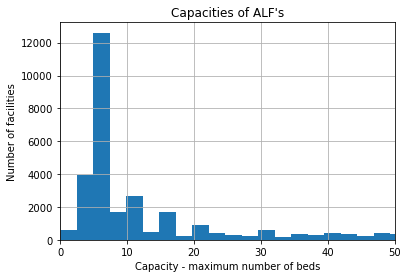

In [32]:
capacities.hist(bins=500)
plt.xlim([0,50])
plt.title("Capacities of ALF's")
plt.xlabel('Capacity - maximum number of beds')
plt.ylabel('Number of facilities')
plt.show()

In [33]:
capacity_mode = capacities.mode()[0]
capacity_mean = capacities.mean()
alf_df['Capacity Estimate Mode'] = [capacity_mode if np.isnan(x) else x for x in alf_df['Capacity']]
alf_df['Capacity Estimate Mean'] = [capacity_mean if np.isnan(x) else x for x in alf_df['Capacity']]

In [34]:
capacity_mode, capacity_mean

(6.0, 32.710443247831506)

In [35]:
alf_df['Capacity'].sum(), alf_df['Capacity Estimate Mode'].sum(), alf_df['Capacity Estimate Mean'].sum()

(1233151.0, 1267351.0, 1419600.5265126396)

## Calculating distances to facilities

In [36]:
# discounting need
# for example, 'home_care_percent = 0.1' means that 10% of people with ALF need choose not to look for 
# an ALF bed because they are satisfied by home care.

home_care_percent = 0
personal_choice_percent = 0
other_percent = 0
discounted_rate = 1 - home_care_percent - personal_choice_percent - other_percent

In [37]:
# creating trees of all ALF data and all NH data
alf_kdtree = KDTree(alf_df[['Latitude', 'Longitude']].values)
# nh_kdtree = KDTree(nh_df[['Latitude', 'Longitude']].values)

In [38]:
county_mean_distance_alf = county_info_df.apply(get_mean_distance_to_alf, scalar=discounted_rate, capacity_type='Capacity Estimate Mean', axis=1)
# county_mean_distance_nh = county_info_df.apply(get_mean_distance_to_nh, scalar=discounted_rate, axis=1)

## Graphing county distances

In [39]:
# getting dict of county info from plotly
counties = requests.get('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json').json()

In [40]:
data = pd.concat([county_info_df['State'], county_info_df['FIPS'], county_mean_distance_alf], axis=1)
data.columns = ['State', 'FIPS', 'ALF Distance']
data['Number of ALF Beds'] = [alf_df[alf_df['County FIPS'] == fips]['Capacity'].sum() for fips in data['FIPS']]
data['Formatted FIPS'] = data['FIPS'].apply(lambda x: str(x).zfill(5))

data['Old Population'] = [int(county_oldpopulation_df.loc[county_oldpopulation_df['FIPS'] == fips]['65+ Population'].values[0]) if county_oldpopulation_df.loc[county_oldpopulation_df['FIPS'] == fips].shape[0] == 1 and not np.isnan(county_oldpopulation_df.loc[county_oldpopulation_df['FIPS'] == fips]['65+ Population'].values[0]) else 0 for fips in data['FIPS'] ]
data['ALF Penetration Per 1000 Elderly'] = 1000 * data['Number of ALF Beds'] / data['Old Population']

states_with_capacity = alf_df[~alf_df['Capacity'].isna()]['State'].unique()

In [41]:
data

,State,FIPS,ALF Distance,Number of ALF Beds,Formatted FIPS,Old Population,ALF Penetration Per 1000 Elderly
0,AL,1001,52.424739,104.0,01001,14,7428.571429
1,AL,1003,106.886066,816.0,01003,19,42947.368421
2,AL,1005,47.346438,32.0,01005,18,1777.777778
3,AL,1007,30.967401,0.0,01007,15,0.000000
4,AL,1009,37.494061,82.0,01009,17,4823.529412
...,...,...,...,...,...,...,...
3138,WY,56037,151.320112,89.0,56037,11,8090.909091
3139,WY,56039,78.379582,0.0,56039,14,0.000000
3140,WY,56041,68.412687,32.0,56041,13,2461.538462
3141,WY,56043,67.245350,0.0,56043,21,0.000000


In [42]:
def discrete_colors(row):
    if row['ALF Penetration Per 1000 Elderly'] == 0:
        return 'No ALFs'
    elif row['ALF Penetration Per 1000 Elderly'] < 15:
        return '1-15'
    elif row['ALF Penetration Per 1000 Elderly'] < 25:
        return '15-25'
    elif row['ALF Penetration Per 1000 Elderly'] < 40:
        return '25-40'
    else:
        return '40+'

data['ALF Penetration Per 1000 Elderly Discrete'] = data.apply(discrete_colors, axis=1)

This is only for counties for which we have AL data.


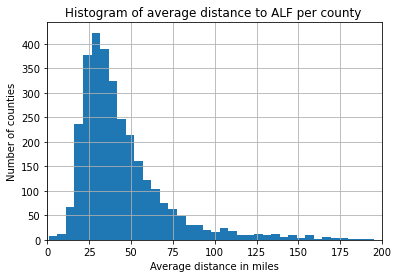

In [43]:
data[data['State'].isin(states_with_alf_data)]['ALF Distance'].hist(bins=500)
plt.title('Histogram of average distance to ALF per county ')
plt.xlabel('Average distance in miles')
plt.ylabel('Number of counties')
plt.xlim([0,200])
print('This is only for counties for which we have AL data.')
plt.show()

This is only for counties for which we have AL data.


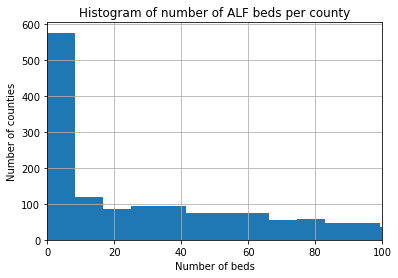

In [44]:
data[data['State'].isin(states_with_capacity)]['Number of ALF Beds'].hist(bins=5000)
plt.title('Histogram of number of ALF beds per county')
plt.xlabel('Number of beds')
plt.ylabel('Number of counties')
plt.xlim([0,100])
print('This is only for counties for which we have AL data.')
plt.show()

In [45]:
"""data[data['State'].isin(states_with_capacity)]['ALF Penetration Per 1000 Elderly'].hist(bins=500)
plt.title('Histogram of ALF Penetration Per 1000 Elderly')
plt.xlabel('Number of beds per person')
plt.ylabel('Number of counties')
plt.xlim([0,100])
print('This is only for counties for which we have AL data.')
plt.show()"""

"data[data['State'].isin(states_with_capacity)]['ALF Penetration Per 1000 Elderly'].hist(bins=500)\nplt.title('Histogram of ALF Penetration Per 1000 Elderly')\nplt.xlabel('Number of beds per person')\nplt.ylabel('Number of counties')\nplt.xlim([0,100])\nprint('This is only for counties for which we have AL data.')\nplt.show()"

In [54]:
data = data.rename(columns={'ALF Distance': 'Distance (miles)'})

In [107]:
# graph of ALF distance

# VSCode update broke plotly visualization below. Can still save to disk with writeimage() and that will show visualization properly

fig = px.choropleth(data, geojson=counties, locations='Formatted FIPS', color='Distance (miles)',
                           color_continuous_scale="Viridis",
                           range_color=(0, 150),
                           scope="usa",
                           labels={'Alf Distance test':'Distance (mi)'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_coloraxes(colorbar_len = .67) 
fig.update_coloraxes(colorbar_thickness = 20) 
fig.update_coloraxes(colorbar_title_side='right')
fig.update_coloraxes(colorbar_x=.95)

#fig.write_image("../data/TESTING.pdf")

py.iplot(fig, filename='TESTEST')

# fig.show()

PlotlyRequestError: This file is too big! Your current subscription is limited to 524.288 KB uploads. For more information, please visit: https://plotly.com/get-pricing/.

In [98]:
# fig.write_image("alf-datasets/national/alf-county-distances-graph-8-27-21.pdf")

In [77]:
"""# graph of number of ALF Beds
# only graphing for counties in states that we have ALF data for

# VSCode update broke plotly visualization below. Can still save to disk with writeimage() and that will show visualization properly

fig = px.choropleth(data[data['State'].isin(states_with_capacity)], geojson=counties, locations='FIPS', color='Number of ALF Beds',
                           color_continuous_scale="Viridis",
                           range_color=(0, 150),
                           title='Distance to Assited Living Bed for Someone with AL Need',
                           scope="usa",
                           labels={'Alf Distance':'Distance (mi)'}
                          )
fig = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
# fig.show()"""

'# graph of number of ALF Beds\n# only graphing for counties in states that we have ALF data for\n\n# VSCode update broke plotly visualization below. Can still save to disk with writeimage() and that will show visualization properly\n\nfig = px.choropleth(data[data[\'State\'].isin(states_with_capacity)], geojson=counties, locations=\'FIPS\', color=\'Number of ALF Beds\',\n                           color_continuous_scale="Viridis",\n                           range_color=(0, 150),\n                           title=\'Distance to Assited Living Bed for Someone with AL Need\',\n                           scope="usa",\n                           labels={\'Alf Distance\':\'Distance (mi)\'}\n                          )\nfig = fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})\n# fig.show()'

In [78]:
"""# graph of number of ALF Beds per person 65+
# only graphing for counties in states that we have ALF data for

# VSCode update broke plotly visualization below. Can still save to disk with writeimage() and that will show visualization properly

fig = px.choropleth(data[data['State'].isin(states_with_capacity)], geojson=counties, locations='FIPS', color='ALF Penetration Per 1000 Elderly Discrete', 
                           color_discrete_sequence=["#f9f374", "#debb46", "#fefefe", "#440a08", "#9b5d21"],
                           title='Distance to Assited Living Bed for Someone with AL Need',
                           scope="usa",
                           labels={'Alf Distance':'Distance (mi)'}
                          )
fig = fig.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0}
)
#fig['layout']['geo']['subunitcolor']='rgba(0,0,0,0)'
fig.update_traces(marker_line_width=0)
# fig.show()"""

'# graph of number of ALF Beds per person 65+\n# only graphing for counties in states that we have ALF data for\n\n# VSCode update broke plotly visualization below. Can still save to disk with writeimage() and that will show visualization properly\n\nfig = px.choropleth(data[data[\'State\'].isin(states_with_capacity)], geojson=counties, locations=\'FIPS\', color=\'ALF Penetration Per 1000 Elderly Discrete\', \n                           color_discrete_sequence=["#f9f374", "#debb46", "#fefefe", "#440a08", "#9b5d21"],\n                           title=\'Distance to Assited Living Bed for Someone with AL Need\',\n                           scope="usa",\n                           labels={\'Alf Distance\':\'Distance (mi)\'}\n                          )\nfig = fig.update_layout(\n    margin={"r":0,"t":0,"l":0,"b":0}\n)\n#fig[\'layout\'][\'geo\'][\'subunitcolor\']=\'rgba(0,0,0,0)\'\nfig.update_traces(marker_line_width=0)\n# fig.show()'

In [49]:
fig.write_image("../data/TESTING.pdf")
# fig.write_image("alf-datasets/national/alf-county-distances-graph-8-27-21.pdf")

## graphing all NHs and ALFs for lightning pres

In [114]:
alf_df_compact = alf_df[['Latitude', 'Longitude']]
nh_df_compact = nh_df[['Latitude', 'Longitude']]

In [108]:
fig = go.Figure(data=go.Scattergeo(
        lon = alf_df_compact['Longitude'],
        lat = alf_df_compact['Latitude'],
        mode = 'markers',
        marker = dict(
                size = 2,
                color = '#326ba8',
                opacity = 0.4
        )
        ))

fig.update_layout(
        geo_scope='usa',
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)'
    )
# fig.show()

NameError: name 'alf_df_compact' is not defined

In [124]:
fig.write_image("../data/other-data/al-graph.pdf")

In [110]:
fig = go.Figure(data=go.Scattergeo(
        lon = nh_df_compact['Longitude'],
        lat = nh_df_compact['Latitude'],
        mode = 'markers',
        marker = dict(
                size = 2,
                color = '#a83258',
                opacity = 0.4
        )
        ))

fig.update_layout(
        title = '',
        geo_scope='usa',
    )

NameError: name 'nh_df_compact' is not defined

In [127]:
fig.write_image("../data/other-data/nh-graph.pdf")